# Basic imputation methods

In this notebook we will analyze and implement the follow basic imputations methods on a Random Walk (which is a good approximation to stock prices in an efficient market):

- Simply dropping values
- Last observed value carried forward (LOCF) 
- Mean imputation
- Interpolation

In [1]:
import numpy as np
import pandas as pd

In [2]:
np.random.seed(1024)

In [3]:
# random fluctuations taken from a normal distribution of mean and variance
mean = 0
var = 1

The NYSE and NASDAQ average about 252 trading days a year. This is from 365.25 (days on average per year) * 5/7 (proportion work days per week) - 6 (weekday holidays) - 4*5/7 (fixed date holidays) = 252.03 ≈ 252. https://en.wikipedia.org/wiki/Trading_day

In [4]:
price_movement = pd.Series(mean + var*np.random.randn(252))

In [5]:
price_series = 100+price_movement.cumsum()

<Axes: >

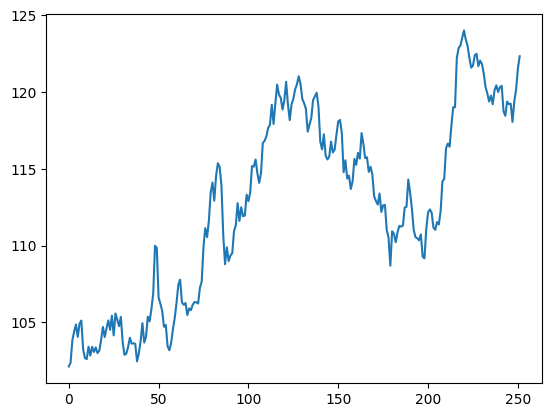

In [6]:
price_series.plot()

In [7]:
price_diffs = price_series.diff()
price_diffs.iloc[0]=0
price_diffs

0      0.000000
1      0.252646
2      1.454179
3      0.569240
4      0.458224
         ...   
247   -1.186374
248    1.342105
249    0.745738
250    1.378936
251    0.812603
Length: 252, dtype: float64

<Axes: >

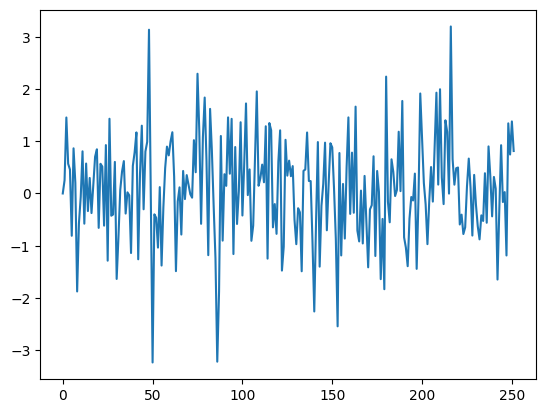

In [8]:
price_diffs.plot()

In [9]:
price_diffs.mean()

0.08019050146054489

In [10]:
price_movement.mean()

0.08862085315728387

# Delete a few data points now

In [24]:
del price_series_na
price_series_na = price_series.copy()
price_series_na.iloc[130:140] = np.array([np.NaN, np.NaN, np.NaN, np.NaN, np.NaN, np.NaN, np.NaN, np.NaN, np.NaN, np.NaN])

In [25]:
# note that this operation is not the correct thing to do. pd.mean() removes NA values automatically
price_series_na.diff().mean() 

0.09977998602618778

In [26]:
price_series_na.dropna().diff().mean()

0.08385064883011333

we see that mean of price differences computed after dropping na values is nearly the same as before

<Axes: >

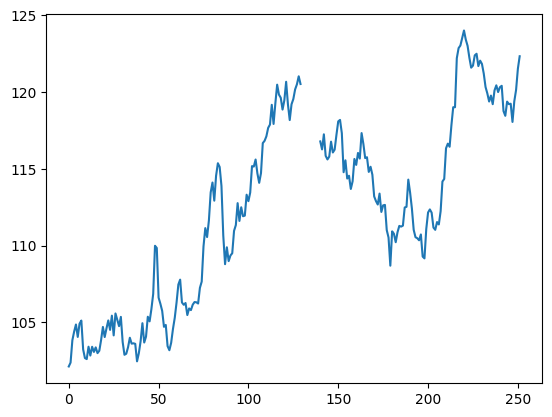

In [27]:
price_series_na.plot()

<Axes: >

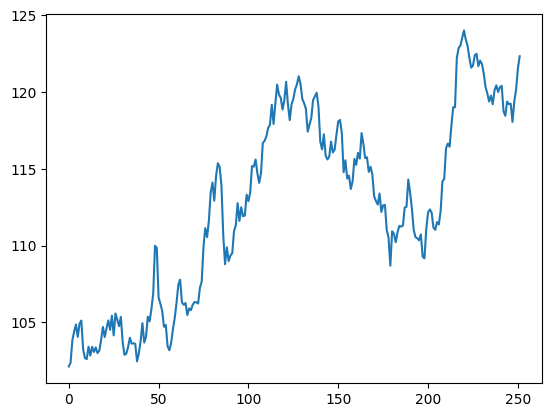

In [28]:
price_series.plot()

# Let us now impliment the LOCF using pandas pd.ffill

The last observed value carried forward impliments what is called a Martingale. Mathematically, a stochastic process $\{X_1, X_2, \cdots X_n\}$ is said to be martingale if the expectation:
\begin{equation}
\mathbb{E}(X_{i+1}| X_1, X_2, \cdots X_i) = X_i
\end{equation}

is given by the last observed value. An example of a Martingale is Random Walk. Under the efficient market hypothesis, the best prediction that one can make for the expected future price discounted to the present time is today’s price itself. Assuming efficient market hypothesis asset price is a martingale

In [33]:
price_series_na.ffill().diff().mean()

0.08050998553010881

In [34]:
price_series_na.dropna().diff().mean()

0.08385064883011333

In [35]:
price_series.dropna().diff().mean()

0.08050998553010881

In [37]:
price_series_na.ffill().diff().iloc[128:141]

128    0.524071
129   -0.503478
130    0.000000
131    0.000000
132    0.000000
133    0.000000
134    0.000000
135    0.000000
136    0.000000
137    0.000000
138    0.000000
139    0.000000
140   -3.739190
dtype: float64

<Axes: >

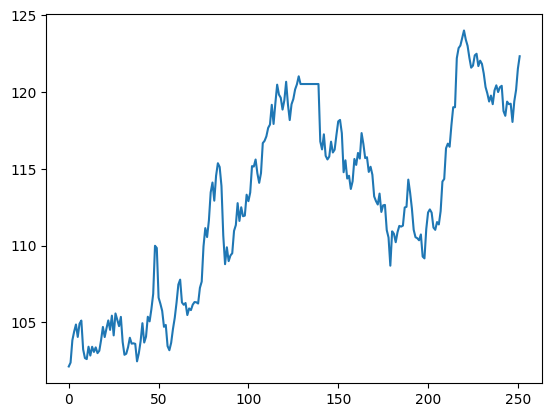

In [86]:
price_series_na.ffill().plot()

# Mean imputation (using the look-back mean)

In [87]:
price_series_na_meanImpute = price_series_na.copy()
# price_series_na_meanImpute[price_series_na_meanImpute.isna()] = price_vec_na.iloc[:90].mean()
# price_vec_na_impute.diff().mean()

In [90]:
price_series_na_meanImpute[price_series_na_meanImpute.isna()]

130   NaN
131   NaN
132   NaN
133   NaN
134   NaN
135   NaN
136   NaN
137   NaN
138   NaN
139   NaN
dtype: float64

In [91]:
price_series_na_meanImpute[price_series_na_meanImpute.isna()] = price_series_na_meanImpute.iloc[:130].mean()

In [94]:
price_series_na_meanImpute.diff().mean() # we get the same mean as price_series_na.ffill().diff().mean()

0.08050998553010881

<Axes: >

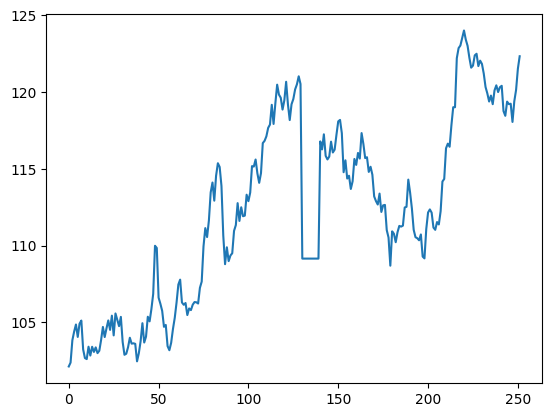

In [95]:
price_series_na_meanImpute.plot()

We make a note here that an actual missing financial data is typically accompanied with outlier data. This can happen if for instance trading gets halted after the spike (determined by the outlier data). After market reacts to the shock, the price can go back to normal.

In [98]:
np.sqrt(1-0.4**2)+0.4/3

1.0498484723245014

In [97]:
0.4/3

0.13333333333333333

# Cross-sectional analysis

suppose we have another stock that is correlated to `price_series` 

<Axes: >

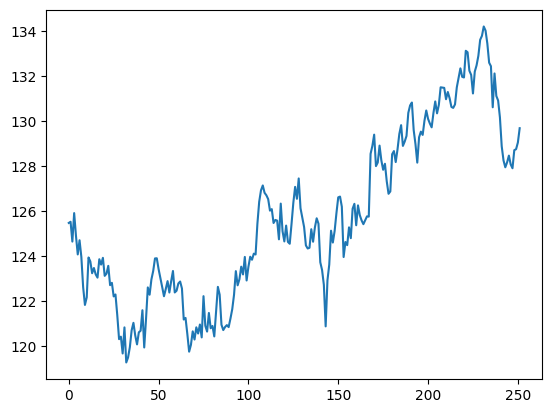

In [128]:
np.random.seed(2)
mean = 0
var = 1
price_movement2 = pd.Series(mean + var*np.random.randn(252))
correlation = 0.35
# gaussian_mixure = (correlation*price_movement + np.sqrt(1-correlation**2)*price_movement2)
gaussian_mixure = (correlation*price_movement + (1-correlation)*price_movement2) # this is the correct definition of the gaussian mixture model
price_series2 = 125+gaussian_mixure.cumsum()
price_series2.plot()

<Axes: >

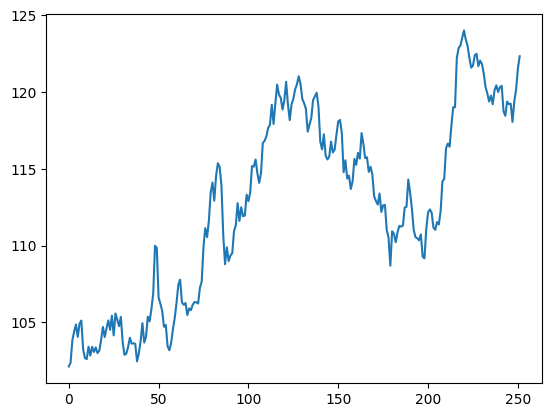

In [129]:
price_series.plot()

In [130]:
pd.concat([price_series, price_series2], axis = 1).head()

,0,1
0,102.124449,125.472664
1,102.377095,125.524517
2,103.831274,124.644952
3,104.400513,125.910362
4,104.858737,124.905007


In [131]:
pd.concat([price_series, price_series2], axis = 1).diff().head()

,0,1
0,NaN,NaN
1,0.252646,0.051853
2,1.454179,-0.879565
3,0.569240,1.265410
4,0.458224,-1.005355


In [132]:
pd.concat([price_series, price_series2], axis = 1).diff().corr()

,0,1
0,1.000000,0.389399
1,0.389399,1.000000


In [133]:
pd.concat([price_series, price_series2], axis = 1).diff().corr().iloc[0,1]

0.3893992340254641

## Regress one price movement over the other

In [134]:
import statsmodels.formula.api as smf

smf.ols('y ~ x',  # this includes intercept by default
        pd.concat([price_series, price_series2], axis = 1, keys = ['x', 'y']).diff()).fit().params[1]

/var/folders/xf/nrh10nbn72g0qqwyvykmn5qh0000gp/T/ipykernel_61929/3555100587.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  smf.ols('y ~ x',  # this includes intercept by default


0.29882794505686683

# Studying the properties of a real daily stock price series

In [39]:
import yfinance as yf

In [135]:
goog = yf.Ticker("GOOG")

In [40]:
aapl = yf.Ticker("AAPL")

In [50]:
aapl_data = aapl.history(period="1y")

In [136]:
goog_data = goog.history(period="1y")

In [51]:
len(aapl_data)

252

In [52]:
aapl_data.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2023-05-18 00:00:00-04:00,172.086086,174.314258,171.668307,174.125259,65496700,0.0,0.0
2023-05-19 00:00:00-04:00,175.458194,175.458194,174.015856,174.234695,55772400,0.0,0.0
2023-05-22 00:00:00-04:00,173.060900,173.787055,172.533701,173.279739,43570900,0.0,0.0
2023-05-23 00:00:00-04:00,172.215400,172.464079,170.375167,170.653687,50747300,0.0,0.0
2023-05-24 00:00:00-04:00,170.186182,171.509158,169.619201,170.932220,45143500,0.0,0.0


In [53]:
aapl_data = aapl_data.reset_index()

In [137]:
goog_data = goog_data.reset_index()

In [54]:
aapl_data.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2023-05-18 00:00:00-04:00,172.086086,174.314258,171.668307,174.125259,65496700,0.0,0.0
1,2023-05-19 00:00:00-04:00,175.458194,175.458194,174.015856,174.234695,55772400,0.0,0.0
2,2023-05-22 00:00:00-04:00,173.060900,173.787055,172.533701,173.279739,43570900,0.0,0.0
3,2023-05-23 00:00:00-04:00,172.215400,172.464079,170.375167,170.653687,50747300,0.0,0.0
4,2023-05-24 00:00:00-04:00,170.186182,171.509158,169.619201,170.932220,45143500,0.0,0.0


In [55]:
aapl_data["Close"]

0      174.125259
1      174.234695
2      173.279739
3      170.653687
4      170.932220
          ...    
247    186.279999
248    187.429993
249    189.720001
250    189.839996
251    189.869995
Name: Close, Length: 252, dtype: float64

<Axes: >

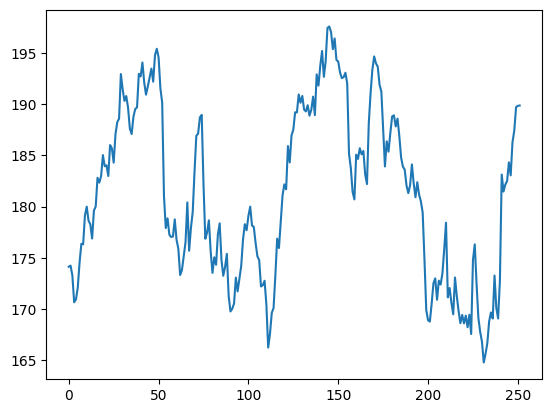

In [56]:
aapl_data["Close"].plot()

<Axes: >

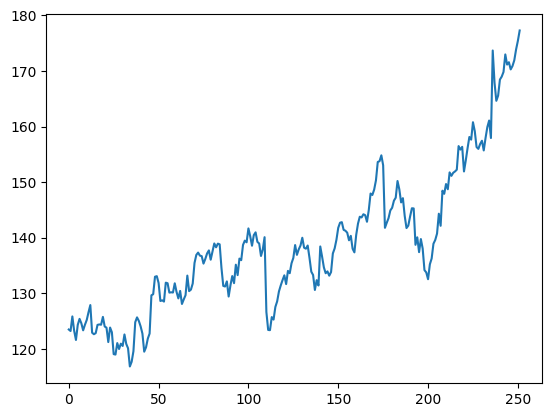

In [138]:
goog_data["Close"].plot()

In [58]:
aapl_data_diffs = aapl_data["Close"].diff()
aapl_data_diffs.iloc[0]=0
aapl_data_diffs

0      0.000000
1      0.109436
2     -0.954956
3     -2.626053
4      0.278534
         ...   
247    3.229996
248    1.149994
249    2.290009
250    0.119995
251    0.029999
Name: Close, Length: 252, dtype: float64

In [63]:
aapl_data_diffs.mean()

0.06247910999116443

In [84]:
aapl_data_diffs.std() # this computes the unbiased standard deviation

2.2865085278781847

In [85]:
aapl_data_diffs.std(ddof=1)

2.2865085278781847

<Axes: >

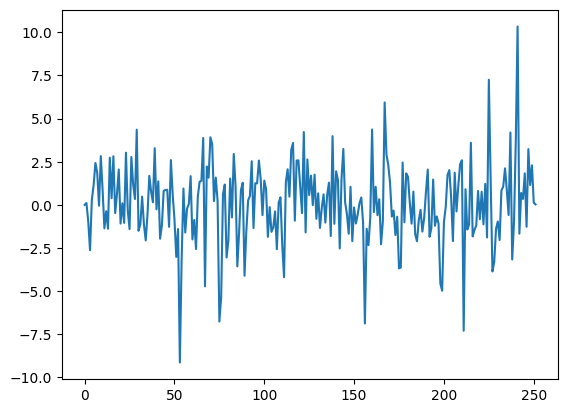

In [59]:
aapl_data_diffs.plot()

In [ ]:
aapl_data_diffs

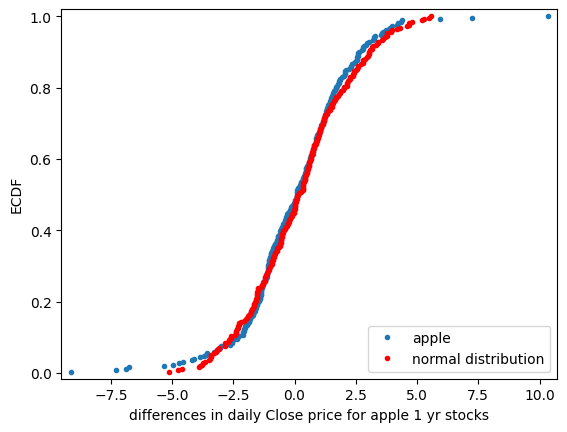

In [79]:
import matplotlib.pyplot as plt

x = np.sort(aapl_data_diffs)
y = np.arange(1, len(x)+1) / len(x)
_ = plt.plot(x, y, marker='.', linestyle='none')

x_2 = np.sort(aapl_data_diffs.mean()+ aapl_data_diffs.std()*np.random.randn(len(x)))
_ = plt.plot(x_2, y, marker='.', linestyle='none', color='red')
_ = plt.xlabel('differences in daily Close price for apple 1 yr stocks')
_ = plt.ylabel('ECDF')
plt.legend(('apple', 'normal distribution'), loc='lower right')
plt.margins(0.02) # Keeps data off plot edgesplt.show()

It looks like the price difference roughly follow a normal distribution with a mean and standard deviation given by the data

In [142]:
pd.concat([goog_data["Close"].diff(), aapl_data["Close"].diff()], axis=1).head(5)

,Close,Close
0,NaN,NaN
1,-0.269997,0.109436
2,2.620003,-0.954956
3,-2.580002,-2.626053
4,-1.650002,0.278534


In [143]:
pd.concat([goog_data["Close"].diff(), aapl_data["Close"].diff()], axis=1).corr()

,Close,Close
Close,1.00000,0.37938
Close,0.37938,1.00000
